In [1]:
# Imports
import numpy
import pandas
import sklearn
import sklearn.dummy
import sklearn.metrics
import sklearn.ensemble

In [2]:
# Matplotlib setup
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

In [3]:
# Load justice-centered SCDB data
scdb_data = pandas.read_csv("data/SCDB_2013_01_justiceCentered_Citation.csv")

## Disposition outcoming coding

  In the section below, we transform the SCDB vote and caseDisposition variables into an outcome variable indicating whether the case overall and each Justice has affirmed or reverse.
  
  * vote: [http://scdb.wustl.edu/documentation.php?var=vote#norms](http://scdb.wustl.edu/documentation.php?var=vote#norms)
  * caseDisposition: [http://scdb.wustl.edu/documentation.php?var=caseDisposition#norms](http://scdb.wustl.edu/documentation.php?var=caseDisposition#norms)

In [4]:
"""
Setup the outcome map.

Rows correspond to vote types.  Columns correspond to disposition types.

Element values correspond to:
 * -1: no precedential issued opinion or uncodable, i.e., DIGs
 * 0: affirm, i.e., no change in precedent
 * 1: reverse, i.e., change in precent
"""
outcome_map = pandas.DataFrame([[-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, 0, 0, 0, -1, 0, -1, -1, -1, -1, -1]])
outcome_map.columns = range(1, 12)
outcome_map.index = range(1, 9)

def get_outcome(vote, disposition):
    """
    Return the outcome code.
    """
    if pandas.isnull(vote) or pandas.isnull(disposition):
        return -1
    
    return outcome_map.loc[int(vote), int(disposition)]

In [5]:
# Map the case-level disposition outcome 
scdb_data.loc[:, "case_outcome_disposition"] = outcome_map.loc[1, scdb_data.loc[:, "caseDisposition"]].values
scdb_data.loc[:, "lc_case_outcome_disposition"] = outcome_map.loc[1, scdb_data.loc[:, "lcDisposition"]].values

# Map the justice-level disposition outcome
scdb_data.loc[:, "justice_outcome_disposition"] = scdb_data.loc[:, ("vote", "caseDisposition")] \
    .apply(lambda row: get_outcome(row["vote"], row["caseDisposition"]), axis=1)

## Running a simulation

  In the section below, we define methods that handle the execution and analysis of simulations.  Simulations are based around the following concepts:
  
  * __pre-processing methods__: pre-processing methods handle cleaning, reshaping, transforming, and encoding input data
  * __prediction methods__: prediction methods take historical data and determine, for each term-justice,  what prediction to make.

In [9]:
# Issue area
issue_area_codes = [0]
issue_area_codes.extend(sorted(scdb_data['issueArea'].fillna(0).apply(int).unique().tolist()))

# Issue
issue_codes = [0]
issue_codes.extend(sorted(scdb_data['issue'].fillna(0).apply(int).unique().tolist()))

# Admin action
admin_action_codes = [0]
admin_action_codes.extend(sorted(scdb_data['adminAction'].fillna(0).apply(int).unique().tolist()))

# Cert reason
cert_reason_codes = [0]
cert_reason_codes.extend(sorted(scdb_data['certReason'].fillna(0).apply(int).unique().tolist()))

# Jurisdiction
jurisdiction_codes = [0]
jurisdiction_codes.extend(sorted(scdb_data['jurisdiction'].fillna(0).apply(int).unique().tolist()))

# LC Disagreement
lc_disagreement_codes = [0]
lc_disagreement_codes.extend(sorted(scdb_data['lcDisagreement'].fillna(0).apply(int).unique().tolist()))

# Justice codes
justice_codes = [0]
justice_codes.extend(sorted(scdb_data['justice'].fillna(0).apply(int).unique().tolist()))

# Jurisdiction
jurisdiction_codes = [0]
jurisdiction_codes.extend(sorted(scdb_data['jurisdiction'].fillna(0).apply(int).unique().tolist()))

# LC outcome
lc_case_outcome_codes = [0]
lc_case_outcome_codes.extend(sorted(scdb_data['lc_case_outcome_disposition'].fillna(0).apply(int).unique().tolist()))

In [65]:
def preprocess_data(data):
    """
    Process SCDB data frame into features.
    """
    # Encode data
    justice_encoded = sklearn.preprocessing.label_binarize(data.loc[:, 'justice'].fillna(0).apply(int),
                                                          justice_codes)
    cert_reason_encoded = sklearn.preprocessing.label_binarize(data.loc[:, 'certReason'].fillna(0).apply(int),
                                                  cert_reason_codes)
    issue_area_encoded = sklearn.preprocessing.label_binarize(data.loc[:, 'issueArea'].fillna(0).apply(int),
                                                  issue_area_codes)
    issue_encoded = sklearn.preprocessing.label_binarize(data.loc[:, 'issue'].fillna(0).apply(int),
                                                  issue_area_codes)
    admin_action_encoded = sklearn.preprocessing.label_binarize(data['adminAction'].fillna(0).apply(int),
                                                  admin_action_codes)
    jurisdiction_encoded = sklearn.preprocessing.label_binarize(data['jurisdiction'].fillna(0).apply(int),
                                                  jurisdiction_codes)
    lc_outcome_encoded = sklearn.preprocessing.label_binarize(data['lc_case_outcome_disposition'].fillna(0).apply(int),
                                                  lc_case_outcome_codes)
    
    # Horizontally stack these column sets together
    return numpy.hstack((justice_encoded, cert_reason_encoded, issue_area_encoded,
                         jurisdiction_encoded, lc_outcome_encoded))

def predict_rf(historical_data, current_data, max_leaf_nodes=256, n_estimators=500):
    """
    Prediction method based on simple random forest classifier.
    
    :param historical_data: SCDB DataFrame to use for out-of-sample calculationi; must be a subset of SCDB justice-centered 
      data known up to point in time
    :param current_data: SCDB DataFrame to use to generate predictions

    :return: vector containing predictions for each current_data record
    """
    
    # Get features and targets
    feature_train_data = preprocess_data(historical_data)
    target_train_data = historical_data.loc[:, "justice_outcome_disposition"].values
    target_index = (target_train_data >= 0)
    
    # Train model
    model = sklearn.ensemble.RandomForestClassifier(max_leaf_nodes=max_leaf_nodes,
                                                    n_estimators=n_estimators, min_samples_leaf=2)
    model.fit(feature_train_data[target_index, :], target_train_data[target_index])
    prediction_score = model.predict_proba(preprocess_data(current_data))
    return prediction_score[:, 1]

def run_simulation(simulation_data, term_list,  prediction_method, score_method="binary"):
    """
    This method defines the simulation driver.
    
    :param simulation_data: SCDB DataFrame to use for simulation; must be a subset of SCDB justice-centered data
    :param term_list: list of terms to simulate, e.g., [2000, 2001, 2002]
    :param prediction_method: method that takes historical data and indicates, by justice,  predictions for term
    :param score_method: "binary" or "stratified"; binary maps to score >= 0.5, stratified maps to score <= random
    :return: copy of simulation_data with additional columns representing predictions
    """
    # Initialize predictions
    return_data = simulation_data.copy()
    return_data.loc[:, "prediction"] = numpy.nan
    return_data.loc[:, "prediction_score"] = numpy.nan

    # Iterate over all terms
    for term in term_list:
        print(term)
        # Get indices for dockets to predict and use for historical data
        before_term_index = simulation_data.loc[:, "term"] < term
        current_term_index = (simulation_data.loc[:, "term"] == term) & (simulation_data.loc[:, "justice_outcome_disposition"] >= 0)

        # Get the list of justices
        term_justices = sorted(simulation_data.loc[current_term_index, "justice"].unique().tolist())

        # Get the predictions
        return_data.loc[current_term_index, "prediction_score"] =  prediction_method(simulation_data.loc[before_term_index, :],
                                                                                simulation_data.loc[current_term_index, :])

        # Support both most_frequent and stratified approaches
        if score_method == "binary":
            return_data.loc[current_term_index, "prediction"] = (return_data.loc[current_term_index, "prediction_score"] >= 0.5).apply(int)
        elif score_method == "stratified":
            return_data.loc[current_term_index, "prediction"] = (return_data.loc[current_term_index, "prediction_score"] >= numpy.random.random(return_data.loc[current_term_index].shape[0])).apply(int)
        else:
            raise NotImplementedError

    # Get the return range and return
    term_index = return_data.loc[:, "term"].isin(term_list) & (return_data.loc[:, "justice_outcome_disposition"] >= 0)
    return return_data.loc[term_index, :]

In [66]:
# Set parameters
start_term = 1953
end_term = 1963

## Predicting case outcomes with a random forest

  In the simulation below, we demonstrate the performance of the baseline model to predict case outcome based solely on historical court reversal rate.
  
  The results indicate an accuracy of 63.72% with a frequency-weighted F1 score of 49.6%.

In [67]:
# Run simulation for simplest model
print("predict_tree")
output_data = run_simulation(scdb_data, range(start_term, end_term), predict_rf)

predict_tree
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962


In [68]:
# Analyze results
print(sklearn.metrics.classification_report(output_data["justice_outcome_disposition"],
                                      output_data["prediction"]))
print(sklearn.metrics.confusion_matrix(output_data["justice_outcome_disposition"],
                                      output_data["prediction"]))
print(sklearn.metrics.accuracy_score(output_data["justice_outcome_disposition"],
                                      output_data["prediction"]))
print(sklearn.metrics.f1_score(output_data["justice_outcome_disposition"],
                                      output_data["prediction"]))

             precision    recall  f1-score   support

          0       0.51      0.24      0.32      3829
          1       0.65      0.86      0.74      6292

avg / total       0.60      0.62      0.58     10121

[[ 907 2922]
 [ 884 5408]]
0.623950202549
0.739707290384


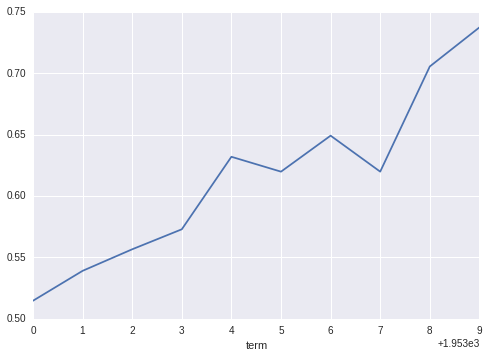

In [69]:
# Get accuracy over time
output_data.loc[:, "correct"] = (output_data["justice_outcome_disposition"] == output_data["prediction"])
court_case_accuracy_by_year = output_data.groupby("term")["correct"].mean()
court_case_accuracy_by_year.plot()

In [70]:
# Run vote simulation
output_data.loc[:, "case_prediction"] = numpy.nan

# Iterate over all dockets
for docket_id, docket_data in output_data.groupby('docketId'):
    # Count predictions from docket
    output_data.loc[:, "case_prediction"]  = int(docket_data.loc[:, "prediction"].value_counts().idxmax())

In [71]:
print(sklearn.metrics.classification_report(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["case_prediction"].fillna(-1)))
print(sklearn.metrics.confusion_matrix(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["case_prediction"].fillna(-1)))
print(sklearn.metrics.accuracy_score(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["case_prediction"].fillna(-1)))
print(sklearn.metrics.f1_score(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["case_prediction"].fillna(-1)))


             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00      3486
        1.0       0.66      1.00      0.79      6635

avg / total       0.43      0.66      0.52     10121

[[   0 3486]
 [   0 6635]]
0.655567631657
0.791955120554
